<a href="https://colab.research.google.com/github/emely3h/Geospatial_ML/blob/feature%2Funet-result-1/result1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
import numpy as np
from tensorflow import keras
import pickle


class EvaluationMetrics:
    """
        This class calculates and summarizes evaluation metrics based on the predicted and true labels.
    """

    def __init__(self, x_train, x_val, x_test, y_train, y_val, y_test, y_pred, training_dates, validation_dates, testing_dates, tile_size, step_size,
                 run_count):
        self.class_statistics = self.get_statistics(x_train, x_val, x_test, y_train, y_val, y_test)

        self.training_dates = training_dates
        self.validation_dates = validation_dates
        self.testing_dates = testing_dates
        self.tile_size = tile_size
        self.step_size = step_size
        self.run_count = run_count

        self.jacard = self.jacard_coef(y_test, y_pred)

        self.conf_matrix_land = self.confusion_matrix(y_test, y_pred, 2)
        self.conf_matrix_valid = self.confusion_matrix(y_test, y_pred, 1)
        self.conf_matrix_invalid = self.confusion_matrix(y_test, y_pred, 0)

        self.f1_land = self.f1_scores(self.conf_matrix_land)
        self.f1_invalid = self.f1_scores(self.conf_matrix_invalid)
        self.f1_valid = self.f1_scores(self.conf_matrix_valid)

    def jacard_coef(self, y_true, y_pred):
        y_true_f = keras.backend.flatten(y_true)
        y_pred_f = keras.backend.flatten(y_pred)

        intersection = keras.backend.sum(y_true_f * y_pred_f)
        return (intersection + 1.0) / (
                keras.backend.sum(y_true_f) + keras.backend.sum(y_pred_f) - intersection + 1.0
        )  #todo reason for +1?

    def jacard_rounding_issue(self, y_true, y_pred):
        # revert one hot encoding => binary tensor [0, 0, 1] back to label [2] (3D array to 2D array)
        label_map_true = np.argmax(y_true, axis=-1)
        label_map_pred = np.argmax(y_pred, axis=-1)
        # convert 2D array into 1D array
        flatten_true = np.reshape(label_map_true, (-1,))
        flatten_pred = np.reshape(label_map_pred, (-1,))
        # one hot encoding
        one_hot_true = np.eye(3)[flatten_true]
        one_hot_pred = np.eye(3)[flatten_pred]
        # calculate intersection (A geschnitten B)
        intersection = np.sum(one_hot_true * one_hot_pred)
        # calculate union (a u B, A vereint B)
        union = len(one_hot_true) + len(one_hot_pred) - intersection
        # return jacard coefficient
        return (intersection + 1) / (union + 1)

    def confusion_matrix(self, y_true, y_pred, label):
        true_positives = 0
        false_positives = 0
        true_negatives = 0
        false_negatives = 0

        # revert one hot encoding => binary tensor [0, 0, 1] back to label [2] (3D array to 2D array)
        label_map_true = np.argmax(y_true, axis=-1)
        label_map_pred = np.argmax(y_pred, axis=-1)
        # convert 2D array into 1D array
        flatten_true = np.reshape(label_map_true, (-1,))
        flatten_pred = np.reshape(label_map_pred, (-1,))

        tp_mask = (flatten_true == flatten_pred) & (flatten_true == label)
        true_positives = np.count_nonzero(tp_mask)

        fn_mask = (flatten_true == label) & (flatten_pred != label)
        false_negatives = np.count_nonzero(fn_mask)

        fp_mask = (flatten_true != label) & (flatten_pred == label)
        false_positives = np.count_nonzero(fp_mask)

        tn_mask = (flatten_true != label) & (flatten_pred != label)
        true_negatives = np.count_nonzero(tn_mask)

        return {
            'true_positives': true_positives,
            'false_positives': false_positives,
            'true_negatives': true_negatives,
            'false_negatives': false_negatives
        }

    def precision(self, conf_matrix):
        return conf_matrix['true_positives'] / (conf_matrix['true_positives'] + conf_matrix['false_positives'])

    def sensitivity_recall(self, conf_matrix):
        return conf_matrix['true_positives'] / (conf_matrix['true_positives'] + conf_matrix['false_negatives'])

    def negative_predictive(self, conf_matrix):
        return conf_matrix['true_negatives'] / (conf_matrix['true_negatives'] + conf_matrix['false_negatives'])

    def specificy(self, conf_matrix):
        return conf_matrix['true_negatives'] / (conf_matrix['true_negatives'] + conf_matrix['false_positives'])

    def f1_scores(self, conf_matrix):
        prec = self.precision(conf_matrix)
        recall = self.sensitivity_recall(conf_matrix)
        return 2 * prec * recall / (prec + recall)

    def print_metrics(self):
        print(f'jacard index: {self.jacard}')
        print(f'conf_matrix_land: {self.conf_matrix_land}')
        print(f'conf_matrix_valid: {self.conf_matrix_valid}')
        print(f'conf_matrix_invalid: {self.conf_matrix_invalid}')
        print(f'f1_land: {self.f1_land}')
        print(f'f1_invalid: {self.f1_invalid}')
        print(f'f1_valid: {self.f1_valid}')
        print(
            f'Training dates: {self.training_dates}, validation dates: {self.validation_dates}, testing dates: {self.testing_dates}')
        print(f'Number of run: {self.run_count}, tile_size: {self.tile_size}, step_size: {self.step_size}')

    def save_to_file(self):
        file_name = f'../metrics/{self.tile_size}_{self.step_size}_{self.run_count}.pkl'
        with open(file_name, 'wb') as file:
            pickle.dump(self, file)

    def get_label_count(self, array):
        revert_one_hot = np.argmax(array, (-1))
        flatten = np.reshape(revert_one_hot, (-1))
        unique_vals, counts = np.unique(flatten, return_counts=True)
        label_count = {}
        for val, count in zip(unique_vals, counts):
            label_count[f'{val}'] = count
        return label_count

    def get_statistics(self, x_train, x_val, x_test, y_train, y_val, y_test):
       return {'y_train': self.get_label_count(y_train),
                 'y_val': self.get_label_count(y_val), 'y_test': self.get_label_count(y_test)}
    # todo add pixel accuracy


**1. Loading results**

In [34]:
from google.colab import drive
drive.mount('/content/drive')
! ls
%cd drive/MyDrive/MachineLearning/metrics/experiment_1
! ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
history_256_200_run_0.pkl  history_256_200_run_7.pkl  metrics_256_200_run_4.pkl
history_256_200_run_1.pkl  history_256_200_run_8.pkl  metrics_256_200_run_5.pkl
history_256_200_run_2.pkl  history_256_200_run_9.pkl  metrics_256_200_run_6.pkl
history_256_200_run_3.pkl  metrics_256_200_run_0.pkl  metrics_256_200_run_7.pkl
history_256_200_run_4.pkl  metrics_256_200_run_1.pkl  metrics_256_200_run_8.pkl
history_256_200_run_5.pkl  metrics_256_200_run_2.pkl  metrics_256_200_run_9.pkl
history_256_200_run_6.pkl  metrics_256_200_run_3.pkl
[Errno 2] No such file or directory: 'drive/MyDrive/MachineLearning/metrics/experiment_1'
/content/drive/.shortcut-targets-by-id/15HUD3sGdfvxy5Y_bjvuXgrzwxt7TzRfm/MachineLearning/metrics/experiment_1
history_256_200_run_0.pkl  history_256_200_run_7.pkl  metrics_256_200_run_4.pkl
history_256_200_run_1.pkl  history_256_200_run_8.pkl  metr

In [35]:
import pickle

with open('metrics_256_200_run_0.pkl', "rb") as file_pi:
  metrics = pickle.load(file_pi)
metrics.print_metrics()

jacard index: 0.9303678274154663
conf_matrix_land: {'true_positives': 38346188, 'false_positives': 489066, 'true_negatives': 43383768, 'false_negatives': 225266}
conf_matrix_valid: {'true_positives': 38091050, 'false_positives': 1166052, 'true_negatives': 42883626, 'false_negatives': 303560}
conf_matrix_invalid: {'true_positives': 3857605, 'false_positives': 494327, 'true_negatives': 76471737, 'false_negatives': 1620619}
f1_land: 0.9907717041784028
f1_invalid: 0.7848512271829662
f1_valid: 0.981074312952688
Training dates: 2022_06_20, validation dates: 2022_07_10, testing dates: 2022_07_25
Number of run: 0, tile_size: 256, step_size: 200


In [36]:
! ls

history_256_200_run_0.pkl  history_256_200_run_7.pkl  metrics_256_200_run_4.pkl
history_256_200_run_1.pkl  history_256_200_run_8.pkl  metrics_256_200_run_5.pkl
history_256_200_run_2.pkl  history_256_200_run_9.pkl  metrics_256_200_run_6.pkl
history_256_200_run_3.pkl  metrics_256_200_run_0.pkl  metrics_256_200_run_7.pkl
history_256_200_run_4.pkl  metrics_256_200_run_1.pkl  metrics_256_200_run_8.pkl
history_256_200_run_5.pkl  metrics_256_200_run_2.pkl  metrics_256_200_run_9.pkl
history_256_200_run_6.pkl  metrics_256_200_run_3.pkl


In [75]:
import os
import pickle

def open_metrics(path):
  data = []
  for root, dirs, files in os.walk(path):
    for file in files:
      if file.startswith('metrics'):
          with open(file,"rb") as f:
            try:
              data.append(pickle.load(f))
            except EOFError:
              break
  return data

metrics_files = open_metrics("./")
print(metrics_files[0].jacard)

tf.Tensor(0.9303678, shape=(), dtype=float32)


In [82]:
import pandas as pd
import numpy
def generate_metrics_df(metrics_files):
  number_of_run = []
  tile_size = []
  step_size = []
  jacard_index = []
  conf_matrix_land = []
  conf_matrix_valid = []
  conf_matrix_invalid = []
  f1_land = []
  f1_invalid = []
  f1_valid = []
  for file in metrics_files:
    number_of_run.append(file.run_count)
    tile_size.append(file.tile_size)
    step_size.append(file.step_size)
    jacard_index.append(file.jacard.numpy())
    conf_matrix_land.append(file.conf_matrix_land)
    conf_matrix_valid.append(file.conf_matrix_valid)
    conf_matrix_invalid.append(file.conf_matrix_invalid)
    f1_land.append(file.f1_land)
    f1_invalid.append(file.f1_invalid)
    f1_valid.append(file.f1_valid)
  
  data = {
      "number_of_run": number_of_run,
      "tile_size":tile_size,
      "step_size": step_size,
      "jacard_index":jacard_index,
      "conf_matrix_land":conf_matrix_land,
      "conf_matrix_valid":conf_matrix_valid,
      "conf_matrix_invalid":conf_matrix_invalid,
      "f1_land":f1_land,
      "f1_invalid":f1_invalid,
      "f1_valid":f1_valid
  }
  df = pd.DataFrame(data)
  return df

In [83]:
metrics_files = open_metrics("./")
print(generate_metrics_df(metrics_files))

   number_of_run  tile_size  step_size  jacard_index  \
0              0        256        200      0.930368   
1              1        256        200      0.959704   
2              2        256        200      0.974950   
3              3        256        200      0.931019   
4              4        256        200      0.978121   
5              5        256        200      0.954100   
6              6        256        200      0.954208   
7              7        256        200      0.958231   
8              8        256        200      0.983031   

                                    conf_matrix_land  \
0  {'true_positives': 38346188, 'false_positives'...   
1  {'true_positives': 38493604, 'false_positives'...   
2  {'true_positives': 38480750, 'false_positives'...   
3  {'true_positives': 38353780, 'false_positives'...   
4  {'true_positives': 38521881, 'false_positives'...   
5  {'true_positives': 38516511, 'false_positives'...   
6  {'true_positives': 38501923, 'false_positive

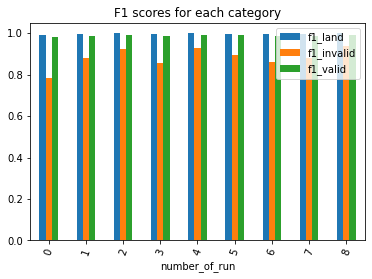

In [86]:
import matplotlib.pyplot as plot
df = generate_metrics_df(metrics_files)
df.plot.bar(x= "number_of_run",y = ["f1_land", "f1_invalid", "f1_valid"], rot=70, title="F1 scores for each category")
plot.show()